In [1]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from IPython.display import Audio, display
def allDone():
    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
import corner
import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import pickle

In [2]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler
import multiprocessing

Using TensorFlow backend.


# Get Data Spectra

In [6]:
wdtable = Table.read('wdtable_sn.fits')

good = (
    (~np.isnan(wdtable['loggH']))*
    (~np.isnan(wdtable['TeffH']))*
    (wdtable['TeffH'] > 13000) * 
    (wdtable['TeffH'] < 80000) * 
    #(wdtable['subclass'] == 'WD')[:,0].data*
    (wdtable['S2N'] > 3)
)
notgoodtable = wdtable[~good]
wdtable = wdtable[good]
len(wdtable)

2255

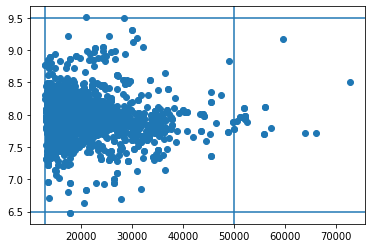

In [7]:
plt.scatter(wdtable['TeffH'],wdtable['loggH'])
plt.axhline(6.5)
plt.axhline(9.5)
plt.axvline(13000)
plt.axvline(50000)

In [8]:
TeffHs = [];
loggHs = [];
specnames = []
spectra = [];

def rvcorr(spectrum):
    lamgrid = np.arange(4000,8000)
    coremask = (lamgrid == 6565)+(lamgrid == 4863)+(lamgrid == 4342)+(lamgrid == 4103)
    coremask = coremask.astype(int)
    trans = np.argmax(np.correlate(1-spectrum,coremask,mode='full'))-4000
    if trans > 5:
        trans = 5;
    elif trans < 5:
        trans = -5;
    else:
        ;
    shiftedspec = interpolation.shift(spectrum,-trans,cval=1)
    return shiftedspec

searchparameter = list(wdtable['specnames'])
bprps = [];
gs = [];
## Enter search parameter, if needed:
inputPath = "../scratch/spec/"

if os.path.exists(inputPath+".DS_Store"):
    os.remove(inputPath+"/.DS_Store")
    
filenames = [i+'.fits' for i in searchparameter]

from scipy.signal import medfilt
from scipy.interpolate import interp1d

len(filenames)

for specname in tqdm(filenames):
    f = fits.open(inputPath+specname)
    loglam = f[1].data['loglam']
    flux = f[1].data['flux']
    lam = 10**loglam
    lam = lam.astype(np.float64)
    flux = flux.astype(np.float64)
    lamgrid = np.arange(4000,8000)
    func = interp1d(lam,flux,kind='cubic',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    spectra.append(flux)
    TeffHs.append(wdtable[wdtable['specnames']==specname[:-5]]['TeffH'][0])
    loggHs.append(wdtable[wdtable['specnames']==specname[:-5]]['loggH'][0])
    bprps.append(wdtable[wdtable['specnames']==specname[:-5]]['bp_rp'][0])
    gs.append(wdtable[wdtable['specnames']==specname[:-5]]['abs_g'][0])
    specnames.append(specname)
spectra = np.asarray(spectra)
TeffHs = np.asarray(TeffHs)
loggHs = np.asarray(loggHs)
bprps = np.asarray(bprps)
gs = np.asarray(gs)

100%|██████████| 2255/2255 [06:07<00:00,  3.11it/s]


In [9]:
lam = np.arange(4000,8000)
lamgrid = lam
lines = ((lam > hbeta-300) & (lam < hbeta + 300)) | ((lam > halpha-400) & (lam < halpha + 400))\
        | ((lam > hgamma-400) & (lam < hgamma + 200))

mask = ~lines | ((lam > 4010) & (lam < 4050)) | ((lam > 4190) & (lam < 4230))
def quadratic(array,c1,c2,c3,c4):
    return c1 + c2*array + c3*array**2 + c4*array**3

In [10]:
normspec = [];

for i in tqdm(range(len(spectra))):
    p,cov = curve_fit(quadratic,lamgrid[mask],spectra[i][mask],p0=[-25,1e-2,1e-5,1e-10])
    contcorr = (spectra[i]/quadratic(lam,p[0],p[1],p[2],p[3]))
    skylinemask = (lamgrid > 5578.5 - 10)*(lamgrid < 5578.5 + 10) + (lamgrid > 5894.6 - 10)*(lamgrid < 5894.6 + 10)\
        + (lamgrid > 6301.7 - 10)*(lamgrid < 6301.7 + 10) + (lamgrid > 7246.0 - 10)*(lamgrid < 7246.0 + 10)
    contcorr[skylinemask] = 1
    #contcorr = rvcorr(contcorr)
    #contcorr = np.log(contcorr)
    trans = wdtable[wdtable['specnames']==specnames[i][:-5]]['centre_beta'][0]-hbeta
    contcorr = interpolation.shift(contcorr,-trans,cval=np.mean(contcorr))
    where = np.isnan(contcorr)
    contcorr[where] = 0
    normspec.append(contcorr[0:3000])
normspec = np.asarray(normspec)
len(normspec)

100%|██████████| 2255/2255 [00:57<00:00, 39.10it/s]


2255

In [12]:
TeffHs = TeffHs[np.max(normspec,1) < 2]
loggHs = loggHs[np.max(normspec,1) < 2]
newspec = normspec[np.max(normspec,1) < 2]

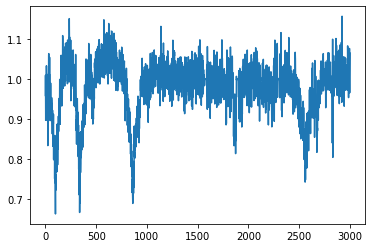

In [13]:
plt.plot(newspec[2])

# Train Generator

In [42]:
sc = StandardScaler()
msc = StandardScaler()
X = msc.fit_transform(normspec)
t = sc.fit_transform(np.stack((TeffHs,loggHs)).transpose())

X_train,X_test,y_train,y_test = train_test_split(X,t,test_size=0.1,random_state=5)

In [43]:
#import keras
def generator():
    x = Input(shape=X[0].shape)
    y = Dense(512,activation='relu')(x)
    y = Dropout(0.7)(y)
    y = Dense(512,activation='relu')(y)
    y = Dropout(0.7)(y)
    out = Dense(t[0].shape[0],activation = 'linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adam(lr=0.001), loss = 'mse', \
                  metrics = ['mae'])
    return model
model = generator()
print(model.summary())

W0802 15:45:41.949201 47585829614912 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0802 15:45:41.971034 47585829614912 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1536512   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 1026      
Total params: 1,800,194
Trainable params: 1,800,194
Non-trainable params: 0
_________________________________________________________________


In [48]:
epoch = 500
batch = len(X_train)
history = [];
vhist = [];
for i in tqdm(range(epoch)):
    h = model.fit(X_train,y_train,epochs=1,verbose=0,batch_size=batch,validation_data = (X_test,y_test))
    history.append(h.history['loss'][0])
    vhist.append(h.history['val_loss'][0])
allDone()

100%|██████████| 500/500 [01:01<00:00,  8.21it/s]


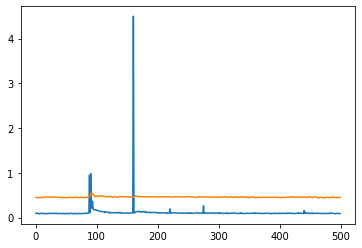

In [49]:
plt.plot((history))
plt.plot((vhist))

In [50]:
truths = sc.inverse_transform(y_test)
preds = sc.inverse_transform(model.predict(X_test))

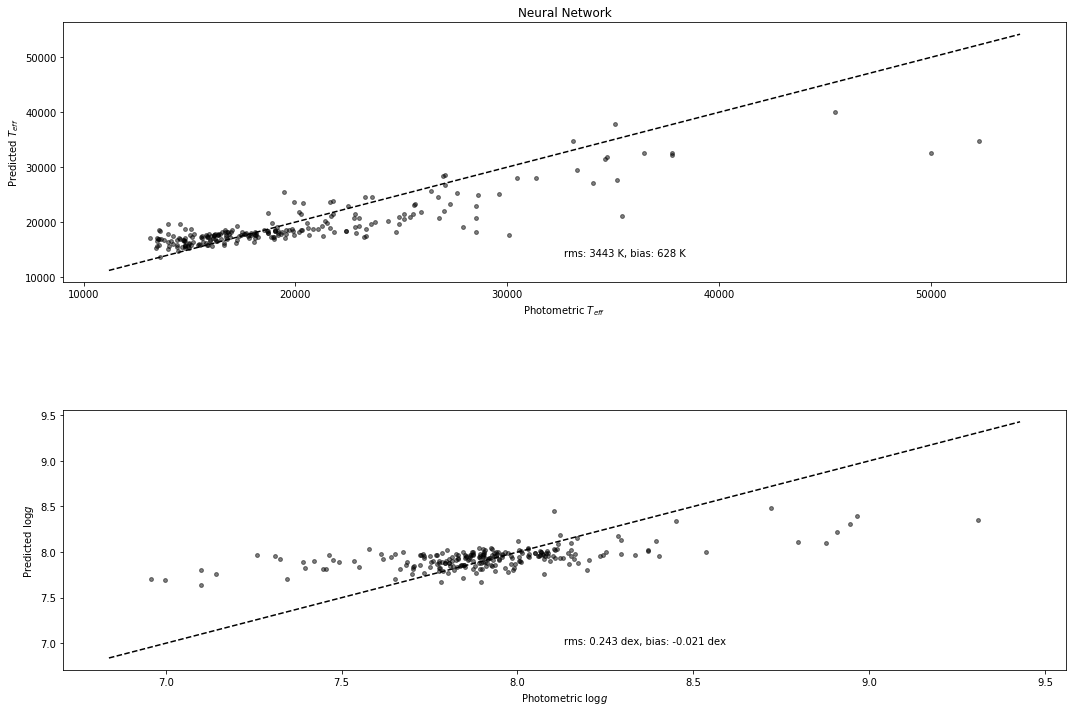

In [51]:
fig,axs=plt.subplots(2,1,figsize=(15,10))
axs[0].scatter(truths[:,0],preds[:,0],s=15,alpha=0.5,color='k')
x = np.linspace(axs[0].get_xlim()[0],axs[0].get_xlim()[1],1000)
y = x
axs[0].plot(x,y,'k--')
axs[0].set_xlabel('Photometric $T_{eff}$')
axs[0].set_ylabel('Predicted $T_{eff}$')

rms = np.sqrt((np.sum((truths[:,0]-preds[:,0])**2) / len(truths[:,0])))
bias = np.mean(truths[:,0]-preds[:,0])
plt.text(0.5,0.1,'rms: %i K, bias: %i K'%(rms,bias),transform=axs[0].transAxes)

axs[1].scatter(truths[:,1],preds[:,1],s=15,alpha=0.5,color='k')
x = np.linspace(axs[1].get_xlim()[0],axs[1].get_xlim()[1],1000)
y = x
axs[1].plot(x,y,'k--')
axs[1].set_xlabel('Photometric $\log{g}$')
axs[1].set_ylabel('Predicted $\log{g}$')

rms = np.sqrt((np.sum((truths[:,1]-preds[:,1])**2) / len(truths[:,1])))
bias = np.mean(truths[:,1]-preds[:,1])
plt.text(0.5,0.1,'rms: %.3f dex, bias: %.3f dex'%(rms,bias),transform=axs[1].transAxes)
axs[0].set_title('Neural Network')
plt.tight_layout()

plt.savefig('neural.pdf')

# Bootstrap Predictions

In [519]:
teffpreds = [];
loggpreds = [];
for i in tqdm(range(10)):
    noisyX = X_test + np.random.normal(0,0.04,X_test.shape)
    teffpreds.append(model.predict(noisyX)[:,0])
    loggpreds.append(model.predict(noisyX)[:,1])










  0%|          | 0/10 [00:00<?, ?it/s]








 10%|█         | 1/10 [00:00<00:01,  5.54it/s]








 20%|██        | 2/10 [00:00<00:01,  5.58it/s]








 30%|███       | 3/10 [00:00<00:01,  5.62it/s]








 40%|████      | 4/10 [00:00<00:01,  5.64it/s]








 50%|█████     | 5/10 [00:00<00:00,  5.62it/s]








 60%|██████    | 6/10 [00:01<00:00,  5.64it/s]








 70%|███████   | 7/10 [00:01<00:00,  5.65it/s]








 80%|████████  | 8/10 [00:01<00:00,  5.67it/s]








 90%|█████████ | 9/10 [00:01<00:00,  5.68it/s]








100%|██████████| 10/10 [00:01<00:00,  5.65it/s]

In [520]:
teffpreds = np.asarray(teffpreds)

In [521]:
tpreds = np.mean(teffpreds,0)
tstds = np.std(teffpreds,0)

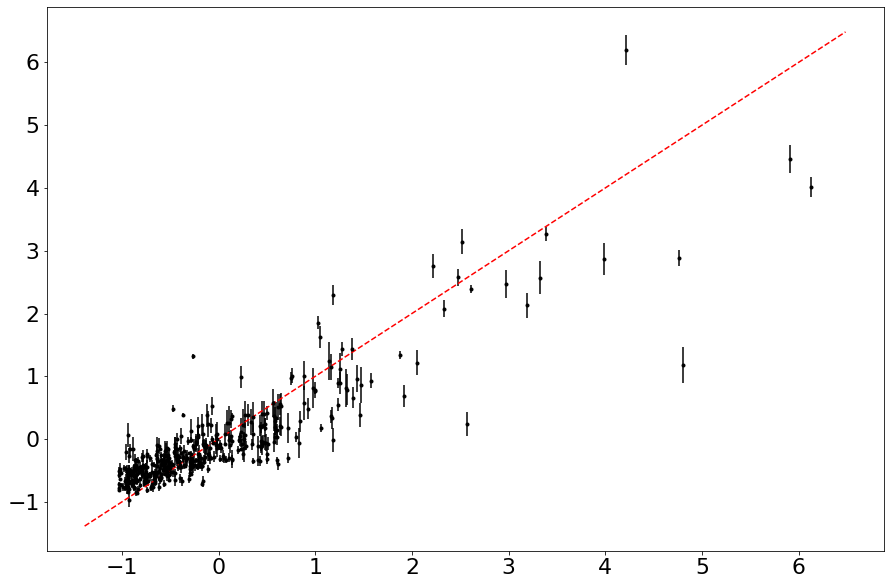

In [527]:
f=plt.subplot(111)
plt.errorbar(y_test[:,0],tpreds,yerr = tstds,linestyle='None',marker='.',color='k')
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')